## Import Library

In [72]:
import os
import numpy as np
import tensorflow as tf
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Input, Conv2D, Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers, optimizers
from IPython.display import display
from PIL import Image 

from time import strftime


## Constants

In [46]:
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS

NR_CLASSES =131

## Gather the Data & Process

In [47]:
train_data_dir = 'Training/'
validation_data_dir = 'Test/'

In [48]:
train_datagen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=20, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=20, class_mode='categorical')


Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [49]:
type(test_datagen)

tensorflow.python.keras.preprocessing.image.ImageDataGenerator

## Build CNN Model

In [54]:
def build_model(lr = 0, dc = 0, dr = 0):
    #create the architecture
    model = Sequential()
    
    #add the 1st convolution layer to extract features from input image
    #feature map: 32*3*3 elu convoluted features
    #subsampling: pooling layer 2*2 pixel filter    
    #add a dropout layer with 20% dropout
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same', input_shape=(100, 100, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    #create NN 256 neurons 1D vector and elu activation
    #add last layer 131 neurons using softmax function 
    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    model.add(Dense(NR_CLASSES, activation='softmax'))
    
    # compile model
    opt = optimizers.Adam(lr = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [55]:
model = build_model(lr = 0.001, dc = 1e-5, dr = 0.5)

In [56]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)       

## Fit the Model

In [60]:
%%time
nr_epochs = 20
model.fit_generator(generator=train_generator, steps_per_epoch = 150, epochs = nr_epochs,validation_data=validation_generator, verbose=1, validation_steps=150, shuffle=True)

Epoch 1/20
150/150 [==============================] - 996s 7s/step - loss: 3.5618 - accuracy: 0.1827 - val_loss: 6.0506 - val_accuracy: 0.0787
Epoch 2/20
150/150 [==============================] - 978s 7s/step - loss: 2.3207 - accuracy: 0.4240 - val_loss: 2.6078 - val_accuracy: 0.3393
Epoch 3/20
150/150 [==============================] - 939s 6s/step - loss: 1.6475 - accuracy: 0.5790 - val_loss: 1.2370 - val_accuracy: 0.6707
Epoch 4/20
150/150 [==============================] - 931s 6s/step - loss: 1.2513 - accuracy: 0.6823 - val_loss: 0.7758 - val_accuracy: 0.8030
Epoch 5/20
150/150 [==============================] - 1077s 7s/step - loss: 0.9881 - accuracy: 0.7470 - val_loss: 0.6961 - val_accuracy: 0.8450
Epoch 6/20
150/150 [==============================] - 1003s 7s/step - loss: 0.8550 - accuracy: 0.7753 - val_loss: 0.5648 - val_accuracy: 0.8677
Epoch 7/20
150/150 [==============================] - 1021s 7s/step - loss: 0.6968 - accuracy: 0.8243 - val_loss: 0.5280 - val_accuracy: 0.8

## Evaluation

In [61]:
def plot_model(history): 
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()

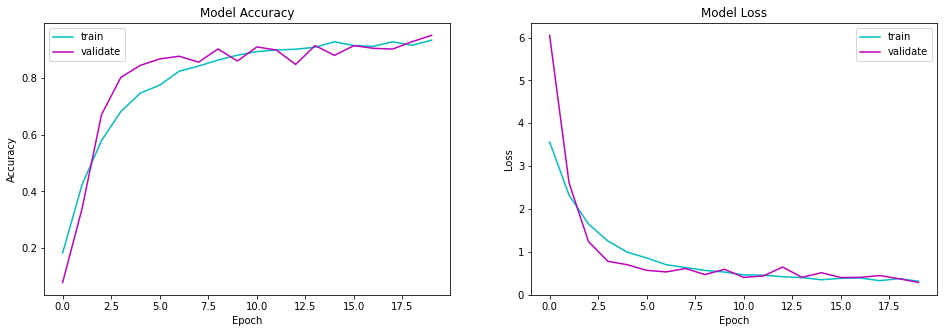

In [62]:
plot_model(model.history)

In [ ]:
#https://www.kaggle.com/volkandl/fruits-classifier-volkandl
#https://github.com/Horea94/Fruit-Images-Dataset/blob/master/src/image_classification/Fruits-360%20CNN.ipynb